# 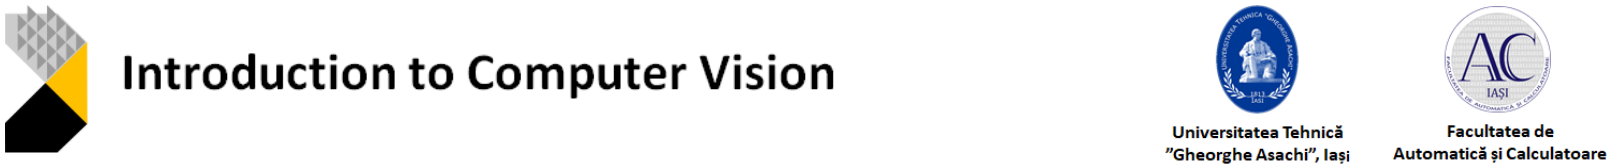

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 2: License plate text recognition

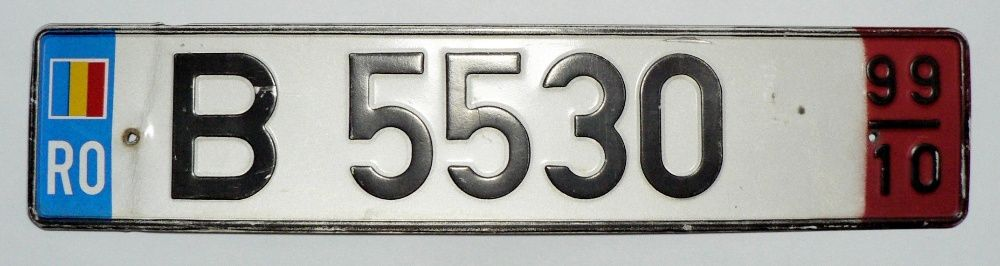

###Label:B
###Prediction output: B
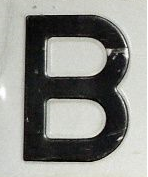

## Week 1: Character classification

In [52]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [53]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        
        if img is not None:
            # Invert image
            inverted_img = cv2.bitwise_not(img)
            
            # Append image and label
            images.append(inverted_img)
            
            # Append image label (first letter of image name: a, b, c, ...)
            labels.append(ord(filename[0]) - ord('a'))
    return images, labels

In [54]:
folder = "letters"
images, labels = load_images_from_folder(folder)

# Let's print the number of images loaded and their corresponding labels
print("Number of images loaded:", len(images))
print("Number of labels loaded:", len(labels))

Number of images loaded: 22
Number of labels loaded: 22


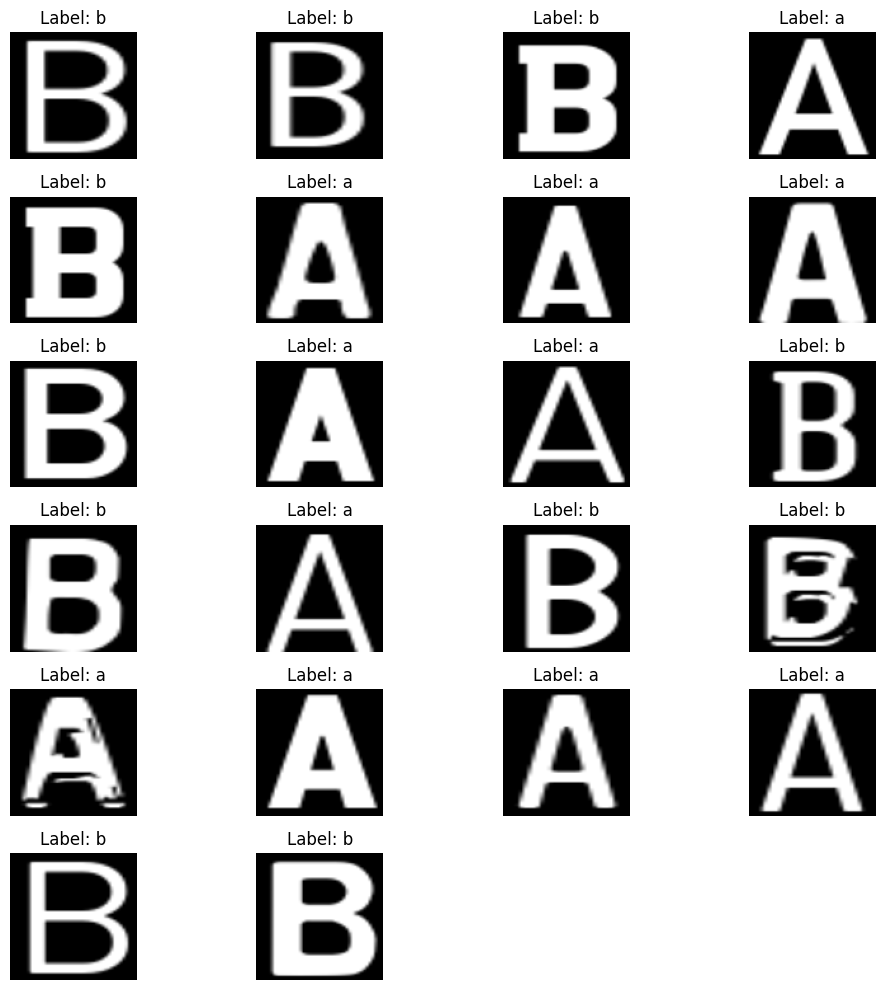

In [55]:
# Function to display images using Matplotlib
def show_images(images, labels):
    num_images = len(images)
    num_cols = 4  # Number of columns in the grid
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

    plt.figure(figsize=(10, 10))  # Adjust the overall size of the grid

    for i in range(num_images):
        resized_image = cv2.resize(images[i], (100, 100))  # Adjust the size as needed
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(resized_image, cmap='gray')
        plt.title("Label: " + chr(labels[i] + ord('a')))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you already have 'images' and 'labels' loaded from the folder
show_images(images, labels)

### Fourier Descriptors
Let $x[m]$ and $y[m]$ be the coordinates of the mth pixel on the boundary of a given 2D shape containing $N$ pixels, a complex number can be formed as $z[m]=x[m]+jy[m]$, and the Fourier Descriptor (FD) of this shape is defined as the DFT of $z[m]$:

$$Z[k] = DFT[z[m]] = \frac{1}{n}\sum_{m=0}^{N-1}z|m|e^{-j2\pi mk/N}$$

FD can be used as a representation of 2D closed shapes independent of its location, scaling, rotation and starting point. For example, we could use $M < N$ FDs corresponding to the low frequency components of the boundary to represent the 2D shape. The reconstructed shape based on these FDs approximate the shape without the details (corresponding to the high frequency components susceptible to noise). However, note that since the Fourier transform is a complex transform, the frequency spectrum has negative frequencies as well as positive frequencies, with the DC component in the middle. Therefore the inverse transform with $M< N$ components needs to contain both positive and negative terms:

$$ ẑ[m]=\sum_{k = -M/2}^{M/2} Z[k] e^{j2\pi mk/N} (m = 0, ..., N-1)$$




To compute the FD:

1. Find object contour (see cv2.findContours)
2. Create complex numbers using the (x, y) coordinates of the contour points: z = x + jy
3. Compute the Fourier transform for every complex number



In [56]:
# Function to compute the fourier descriptors
def findDescriptor(img):
    """ findDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    contour = []
    #Find object contour
    contour, hierarchy = cv2.findContours(
        img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE,
        contour)

    #Create complex number using (x, y) coordinates of the contour points
    contour_array = contour[0][:, 0, :]
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]

    #Apply Fourier Transform (see np.fft)
    fourier_result = np.fft.fft(contour_complex)

    return fourier_result

#Function that keeps a desired number of fourier descriptors (degree)
def truncate_descriptor(descriptors, degree):
    """this function truncates an unshifted fourier descriptor array
    and returns one also unshifted"""
    descriptors = np.fft.fftshift(descriptors)
    center_index = len(descriptors) / 2
    descriptors = descriptors[int(center_index - (degree / 2)):int(center_index + (degree / 2))]
    descriptors = np.fft.ifftshift(descriptors)
    return descriptors

###Input shape and different number of Fourier Descriptors (10, 50, 300)

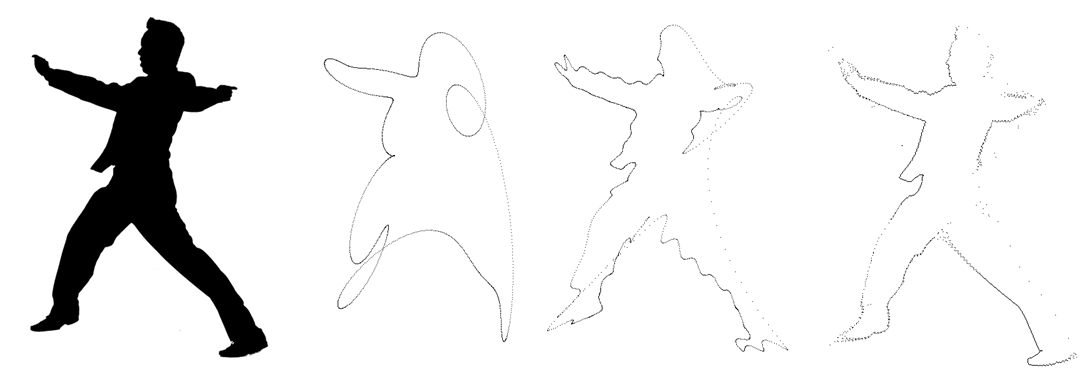

### What are Hu Moments?
**Hu Moments** ( or rather **Hu moment invariants** ) are a set of 7 numbers calculated using **central moments** that are invariant to image transformations. The first 6 moments have been proved to be invariant to **translation**, **scale**, and **rotation**, and **reflection**. While the 7th moment’s sign changes for image reflection.

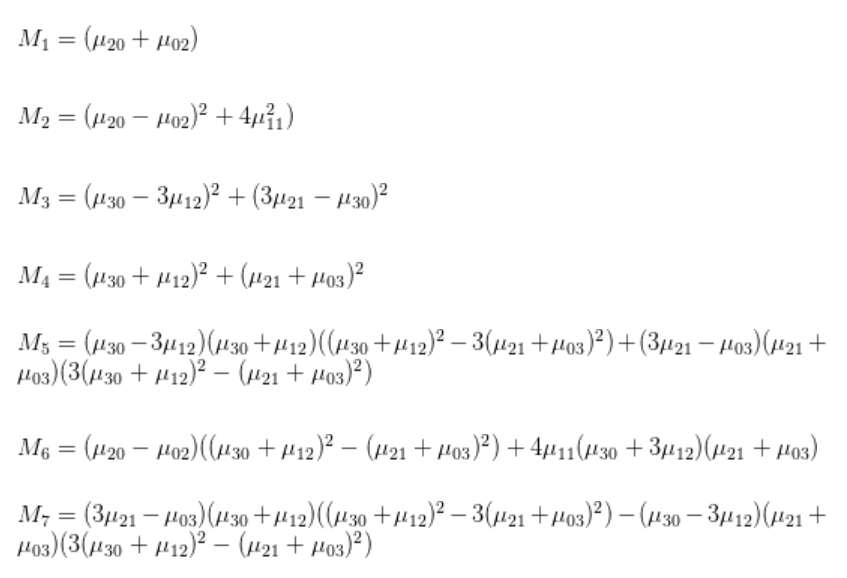

```markdown
Further reading: Analysis of Hu's moment invariants on image scaling and rotation (https://ieeexplore.ieee.org/document/5485542)
```

In [57]:
# Function that computes Hu Moments
# Steps:
# 1. threshold image (see cv2.threshold)
# 2. calculate moments (see cv2.moments)
# 3. compute Hu Moments (see cv2.HuMoments)

def fd_hu_moments(image):
  #step 1 => threshold
  _,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

  #step2 => moments
  moments = cv2.moments(image)

  #step 3 => Hu Moments
  huMoments = cv2.HuMoments(moments).flatten()

  return huMoments

In [58]:
# Function to display images using Matplotlib
def show_image(img, title):
    plt.figure(figsize=(2, 2))  # Half the original size
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

### Test Hu Moments by performing geometric transformations

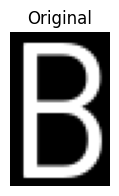

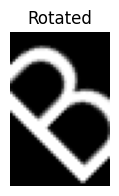

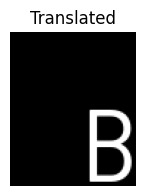

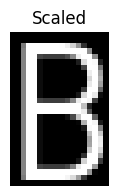

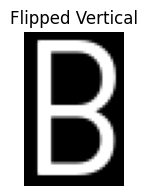

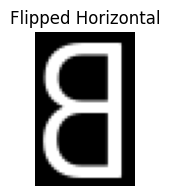

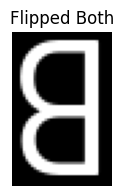

Moment 1
0.0011333090180029066
0.0010890452849774256
0.0007173162945860322
0.0011966583284240301
0.0011333090180029063
0.0011333090180029066
0.0011333090180029063
Moment 2
1.9935390845750559e-07
2.321915446934165e-07
2.551747358815434e-08
2.554914706677213e-07
1.993539084575054e-07
1.9935390845750564e-07
1.9935390845750545e-07
Moment 3
1.076974159864808e-12
3.7679481043666905e-12
2.1009086697439254e-12
7.629941004868627e-13
1.0769741598648913e-12
1.0769741598649877e-12
1.0769741598649307e-12
Moment 4
5.919523971800362e-16
1.3617062873568442e-12
1.0037216236202888e-12
1.770195917684006e-13
5.919523971793724e-16
5.919523971788441e-16
5.919523971793738e-16
Moment 5
1.459499875229935e-29
2.2657817699215926e-24
-9.60278542205647e-25
-3.742774125274607e-26
1.4594998752279937e-29
1.4594998752256648e-29
1.4594998752278786e-29
Moment 6
-2.5727217762551068e-19
2.9238700347093587e-16
7.726533622094216e-18
-4.765902237303511e-17
-2.5727217762527846e-19
-2.572721776249956e-19
-2.5727217762526035e-1

In [59]:
#TODO: compute huMoments on rotated, translated, scaled, flipped (horizontal, vertical, both) input shapes
# (see cv2.getRotationMatrix2D, cv2.warpAffine, cv2.resize)
# https://docs.opencv.org/4.1.2/da/d6e/tutorial_py_geometric_transformations.html

# Function to rotate image
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# Function to translate image
def translate_image(image, tx, ty):
    (h, w) = image.shape[:2]
    
    # Compute new size based on translation
    new_w = w + abs(tx)
    new_h = h + abs(ty)
    
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, M, (new_w, new_h))
    return translated

# Function to flip image
def flip_image(image, flip_code):
    flipped = cv2.flip(image, flip_code)
    return flipped

for img in images:
    try:
        show_image(img, "Original")
        (h, w) = img.shape[:2]
        (cX, cY) = (w // 2, h // 2)
    
        #TODO: rotate image (see cv2.getRotationMatrix2D, cv2.warpAffine)
        #code here
        # Rotate image
        rotated = rotate_image(img, 45)
        show_image(rotated, "Rotated")
     
        #TODO: translate image (cv2.warpAffine)
        # Translate image
        translated = translate_image(img, 50, 50)
        show_image(translated, "Translated")
    
        #TODO: scale image (cv2.resize)
        # Scale image
        scaled = cv2.resize(img, None, fx=0.5, fy=0.5)
        show_image(scaled, "Scaled")
        
        #TODO: flip image (cv2.flip)
        # Flip image
        flipVertical = flip_image(img, 0)  # Flip around x
        show_image(flipVertical, "Flipped Vertical")
        
        flipHorizontal = flip_image(img, 1)  # Flip around y
        show_image(flipHorizontal, "Flipped Horizontal")
        
        flipBoth = flip_image(img, -1)  # Flip around xy
        show_image(flipBoth, "Flipped Both")
    
        hu_img = fd_hu_moments(img)
        hu_rot = fd_hu_moments(rotated)
        hu_trans= fd_hu_moments(translated)
        hu_scal = fd_hu_moments(scaled)
        hu_flipV = fd_hu_moments(flipVertical)
        hu_flipH = fd_hu_moments(flipHorizontal)
        hu_flipVH = fd_hu_moments(flipBoth)
      
        
        for i in range(0, 7):
            print("Moment "+str(i+1))
            print(hu_img[i])
            print(hu_rot[i])
            print(hu_trans[i])
            print(hu_scal[i])
            print(hu_flipV[i])
            print(hu_flipH[i])
            print(hu_flipVH[i])
            
        break
    except Exception as e:
        print("Error occured!", type(e), str(e))

## Week 2: Classifier training and testing

### What is a SVM?
A **Support Vector Machine (SVM)** is a discriminative classifier formally defined by a separating hyperplane. In other words, given **labeled training data (supervised learning)**, the algorithm outputs an optimal hyperplane which categorizes new examples.

In which sense is the hyperplane obtained optimal? Let's consider the following simple problem:

For a linearly separable set of 2D-points which belong to one of two classes, find a separating straight line.

<figure>
<center>
<img src='https://docs.opencv.org/4.1.2/separating-lines.png' />
<figcaption>In this example we deal with lines and points in the Cartesian plane instead of hyperplanes and vectors in a high dimensional space. This is a simplification of the problem.It is important to understand that this is done only because our intuition is better built from examples that are easy to imagine. However, the same concepts apply to tasks where the examples to classify lie in a space whose dimension is higher than two</figcaption></center>
</figure>

In the above picture you can see that there exists multiple lines that offer a solution to the problem. Is any of them better than the others? We can intuitively define a criterion to estimate the worth of the lines: A line is bad if it passes too close to the points because it will be noise sensitive and it will not generalize correctly. Therefore, our goal should be to find the line passing as far as possible from all points.

Then, the operation of the SVM algorithm is based on finding the hyperplane that gives the largest minimum distance to the training examples. Twice, this distance receives the important name of margin within SVM's theory. Therefore, the optimal separating hyperplane maximizes the margin of the training data.

<figure>
<center>
<img src='https://docs.opencv.org/4.1.2/optimal-hyperplane.png' />
</figure>

**How is the optimal hyperplane computed?**
Let's introduce the notation used to define formally a hyperplane:

$$f(x) = 	\beta_{0}+\beta^Tx,$$
where $\beta$ is known as the *weight vector* $\beta_{0}$ as *the bias*. 

```markdown
See also: A more in depth description of this and hyperplanes you can find in the section 4.5 (Separating Hyperplanes) of the book: Elements of Statistical Learning by T. Hastie, R. Tibshirani and J. H. Friedman
```

The optimal hyperplane can be represented in an infinite number of different ways by scaling of $\beta$  and $\beta_{0}$. As a matter of convention, among all the possible representations of the hyperplane, the one chosen is:

$$|\beta_{0}+\beta^Tx| = 1,$$

where $x$ symbolizes the training examples closest to the hyperplane. In general, the training examples that are closest to the hyperplane are called support vectors. This representation is known as the canonical hyperplane.

Now, we use the result of geometry that gives the distance between a point $x$ and a hyperplane $(\beta,\beta_{0})$:


$$distance = \frac{|\beta_{0}+\beta^Tx|}{||\beta||}.$$

In particular, for the canonical hyperplane, the numerator is equal to one and the distance to the support vectors is:
$$distance_{support vectors} = \frac{|\beta_{0}+\beta^Tx|}{||\beta||} = \frac{1}{||\beta||}.$$

(*https://docs.opencv.org/4.1.2/d1/d73/tutorial_introduction_to_svm.html*)





In [60]:
#TODO: Create SVM linear classifier (see cv.ml.SVM_create() from openCV)
# https://docs.opencv.org/4.1.2/d1/d73/tutorial_introduction_to_svm.html
# Create an SVM object
svm = cv2.ml.SVM().create()

#TODO: set SVM params
# Set SVM parameters
svm.setType(cv2.ml.SVM_C_SVC)  # Use C-Support Vector Classification
svm.setKernel(cv2.ml.SVM_LINEAR)  # Use Linear kernel

## Extract features & train SVM

In [61]:
# scale an input array-like to a mininum and maximum number
# the input array must be of a floating point array
# if you have a non-floating point array, convert to floating using `astype('float')`
# this works with n-dimensional arrays
# it will mutate in place
# min and max can be integers
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

### Train&Test SVM with Fourier Descriptors

In [62]:
#features extraction FD
NUM_DESCRIPTORS = 18
global_features = []
for img in images:
  fd = findDescriptor(img) 
  descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)
  descriptors = scale_range(descriptors, 0, 1)
  global_feature = np.hstack([descriptors.real, descriptors.imag])
  global_features.append(global_feature)

In [63]:
#set up training data
class_labels = np.array(labels)
trainingData = np.matrix(global_features,dtype=np.float32)
print(class_labels.shape)
print(trainingData.shape)

(22,)
(22, 36)


In [64]:
#TODO: Train the linear SVM
#code here
svm.train(trainingData, cv2.ml.ROW_SAMPLE, class_labels)

True

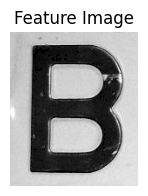

Label: B
Prediction: B


In [66]:
#TODO: Test on image (link below) with Fourier Descriptors
#https://drive.google.com/file/d/1rPsE-M0kxTF_03cZ3sEKhJ2rCc1TgpYp/view?usp=sharing
img = cv2.imread("B (test).png", 0)
#img = images[5]

#TODO: find descriptors -  see findDescriptor
fd = findDescriptor(img)

#TODO: truncate descriptor - see truncate_descriptor
truncated_descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)

#TODO: scale to [0, 1] range the truncated descriptor - see scale_range
scaled_descriptors = scale_range(truncated_descriptors, 0, 1)

#create input to SVM (fd_imag is the scaled truncated descriptor)
FD_feature = np.hstack([scaled_descriptors.real, scaled_descriptors.imag])
testData = np.matrix(FD_feature, dtype=np.float32)

#TODO: feed testData input to SVM (see predict function)
response = svm.predict(testData)[1].ravel()[0]

show_image(img, "Feature Image")
print("Label: B")
print("Prediction: " + chr(int(65 + response)))


### Train&Test SVM with Hu Moments

In [67]:
#TODO: feature extraction of Hu moments for each image, result is a list of lists (global_features)
# Initialize the list to store global features
global_features = []

# Extract Hu moments for each image
for img in images:
    # Extract Hu moments for the current image
    hu_moments = fd_hu_moments(img)
    
    # Append the Hu moments to the global features list
    global_features.append(hu_moments.ravel().tolist())

# Print the shape of the global features list
print("Shape of global features:", np.array(global_features).shape)

Shape of global features: (22, 7)


In [68]:
#TODO: set up labels & training data
# Initialize lists to store features and labels
global_features = []
lbls = []

# Extract Hu moments for each image and associate them with labels
for img, label in zip(images, labels):
    # Extract Hu moments for the current image
    hu_moments = fd_hu_moments(img)
    
    # Append the Hu moments to global features
    global_features.append(hu_moments.ravel().tolist())  # Ravel and convert to list
    
    # Append the label to the labels list
    lbls.append(label)

# Convert lists to numpy arrays for training
X_train = np.array(global_features)  # Features
y_train = np.array(labels)           # Labels

# Print the shapes of the training data
print("Shape of features:", X_train.shape)
print("Shape of labels:", y_train.shape)

Shape of features: (22, 7)
Shape of labels: (22,)


In [69]:
#TODO: Train the SVM with the new training data (Hu moments)
svm_hu = cv2.ml.SVM().create()  # Create an SVM object
svm_hu.setType(cv2.ml.SVM_C_SVC)  # Use C-Support Vector Classification
svm_hu.setKernel(cv2.ml.SVM_LINEAR)  # Use Linear kernel

# Convert X_train to CV_32F
X_train = X_train.astype(np.float32)

# Train the SVM
svm_hu.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

print("SVM trained successfully with Hu moments data.")

SVM trained successfully with Hu moments data.


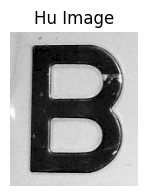

Label: B
Prediction: B


In [70]:
#TODO: Test on image with Hu Moments
img = cv2.imread("B (test).png", 0)

#TODO: compute Hu moments - see fd_hu_moments
hu_moments_test = fd_hu_moments(img)

#TODO: scale the Hu moments to [0, 1] - see scale_range
hu_moments_test_scaled = scale_range(hu_moments_test, 0, 1)

#TODO: cast test data to float32 matrix - see np.matrix
testData_hu = np.matrix(hu_moments_test_scaled, dtype=np.float32)

#TODO: feed data to SVM
response_hu = svm_hu.predict(testData_hu)[1].ravel()[0]

show_image(img, "Hu Image")
#print("Label: "+chr(labels[16]+65))

# Print the label and prediction
print("Label: B")
print("Prediction: " + chr(int(65 + response)))

### Train&Test with Fourier Descriptors and Hu Moments

In [71]:
##TODO: feature extraction FD + Hu Moments for each image
NUM_DESCRIPTORS = 18
global_features = []
#code here
# Extract Fourier descriptors (FD) and Hu moments for each image
for img in images:
    # Extract Fourier descriptors for the current image
    fd = findDescriptor(img) 
    descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)
    descriptors = scale_range(descriptors, 0, 1)
    
    # Extract Hu moments for the current image
    hu_moments = fd_hu_moments(img)
    
    # Combine FD and Hu moments features
    combined_features = np.hstack([descriptors.real, descriptors.imag, hu_moments.ravel()])
    
    # Append the combined features to the global features list
    global_features.append(combined_features)

# Convert the global features list to a numpy array
global_features = np.array(global_features)

# Print the shape of the global features
print("Shape of global features:", global_features.shape)

Shape of global features: (22, 43)


In [72]:
#set up training data
class_labels = np.array(labels)
trainingData = np.matrix(global_features,dtype=np.float32)
print(class_labels.shape)
print(trainingData.shape)

(22,)
(22, 43)


In [73]:
#TODO: Train the SVM
#code here
# Print shapes of class labels and training data
print("Shape of class labels:", class_labels.shape)
print("Shape of training data:", trainingData.shape)

# Train the SVM
svm.train(trainingData, cv2.ml.ROW_SAMPLE, class_labels)


Shape of class labels: (22,)
Shape of training data: (22, 43)


True

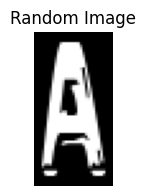

Label: A
Prediction: A


In [74]:
#TODO: Test on random image with FD + Hu Moments
img = images[10]
#code here

# Compute Fourier Descriptors (FD) for the image
fd = findDescriptor(img)

# Truncate the descriptor
truncated_descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)

# Scale the truncated descriptor to the [0, 1] range
scaled_descriptors = scale_range(truncated_descriptors, 0, 1)

# Compute Hu Moments for the image
hu_moments = fd_hu_moments(img)

# Combine FD and Hu Moments features
test_data = np.hstack([scaled_descriptors.real, scaled_descriptors.imag, hu_moments.ravel()])

# Cast test data to float32 matrix
test_data = np.matrix(test_data, dtype=np.float32)

# Feed data to SVM and get prediction
_, response = svm.predict(test_data)

show_image(images[16], "Random Image")

# Print the ground truth label and prediction
print("Label: " + chr(labels[16] + 65))
print("Prediction: " + chr(65 + int(response[0][0])))

In [75]:
import random


def generate_letter_images(output_folder, font_faces):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define parameters
    font_scale = 1
    font_thickness = 2
    font_color = (0, 0, 0)  # Black color for the letters
    image_size = (50, 50)

    # Generate images for each letter from 'C' to 'Z' using random fonts
    for letter_code in range(ord('C'), ord('Z') + 1):
        letter = chr(letter_code)
        for index in range(1, 12):
            img = np.ones((image_size[1], image_size[0], 3), dtype=np.uint8) * 255  # Create a white background image

            # Choose a random font face
            font_face = random.choice(font_faces)

            # Calculate text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(letter, font_face, font_scale, font_thickness)
            text_x = (image_size[0] - text_width) // 2
            text_y = (image_size[1] + text_height) // 2

            # Render text on the image
            cv2.putText(img, letter, (text_x, text_y), font_face, font_scale, font_color, font_thickness, cv2.LINE_AA)

            # Save the image
            img_path = os.path.join(output_folder, f"{letter} ({index}).png")  # Naming convention: uppercase letter and index
            cv2.imwrite(img_path, img)

# Define different font faces available in OpenCV
font_faces = [
    cv2.FONT_HERSHEY_SIMPLEX,
    cv2.FONT_HERSHEY_PLAIN,
    cv2.FONT_HERSHEY_DUPLEX,
    cv2.FONT_HERSHEY_COMPLEX,
    cv2.FONT_HERSHEY_TRIPLEX,
    cv2.FONT_HERSHEY_COMPLEX_SMALL
]

In [76]:
#TODO: complete the training dataset with all uppercase letters, train & test the SVM, is it performing good enough? find a classifier that performs better
# # Generate letter images for letters C-Z using random fonts available in OpenCV and save them in the 'letters' folder
# generate_letter_images("letters", font_faces)

folder = "complete_letters"
images, labels = load_images_from_folder(folder)

print(len(images))
print(len(labels))

286
286


In [ ]:
# Initialize lists to store features
global_features = []

# Extract Fourier Descriptors and Hu Moments for each image
for img in images:
    # Extract Fourier Descriptors for the current image
    fd = findDescriptor(img)
    truncated_fd = truncate_descriptor(fd, NUM_DESCRIPTORS)
    scaled_fd = scale_range(truncated_fd, 0, 1)
    
    # Extract Hu Moments for the current image
    hu_moments = fd_hu_moments(img)
    
    # Combine Fourier Descriptors and Hu Moments
    combined_features = np.hstack([scaled_fd.real, scaled_fd.imag, hu_moments.ravel()])
    
    # Append the combined features to the global features list
    global_features.append(combined_features)

# Convert the global features list to a numpy array with float32 data type
X_train = np.array(global_features, dtype=np.float32)

# Convert the labels to a numpy array with int32 data type
y_train = np.array(labels, dtype=np.int32)

# Create an SVM object
svm = cv2.ml.SVM().create()

# Set SVM parameters
svm.setType(cv2.ml.SVM_C_SVC)  # Use C-Support Vector Classification
svm.setKernel(cv2.ml.SVM_LINEAR)  # Use Linear kernel

# Train the SVM classifier
svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

# Load a test image
test_img = images[1]

# Extract features (Fourier Descriptors and Hu Moments) for the test image
test_fd = findDescriptor(test_img)
test_truncated_fd = truncate_descriptor(test_fd, NUM_DESCRIPTORS)
test_scaled_fd = scale_range(test_truncated_fd, 0, 1)
test_hu_moments = fd_hu_moments(test_img)

# Combine Fourier Descriptors and Hu Moments for the test image
test_combined_features = np.hstack([test_scaled_fd.real, test_scaled_fd.imag, test_hu_moments.ravel()])

# Convert the test features to a float32 matrix
test_data = np.matrix(test_combined_features, dtype=np.float32)

# Feed the test data to the SVM classifier
response = svm.predict(test_data)

print(response)

# Print the prediction
show_image(test_img, "Second Test Image")
print("Prediction:", chr(65 + int(response[1][0][0])))

In [77]:
print(cv2.__version__)

4.9.0
